<a href="https://colab.research.google.com/github/krajak09/Master-Thesis/blob/main/scripts/Train_and_Test_von_FilterLocalLinearTrendModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install filterpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.0/178.0 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for filterpy: filename=filterpy-1.4.5-py3-none-any.whl size=110460 sha256=13342fbfc72ec85eeb676ff602ecd0d5b8425b1c1f217090ce6d9edb639f74af
  Stored in directory: /root/.cache/pip/wheels/77/bf/4c/b0c3f4798a0166668752312a67118b27a3cd341e13ac0ae6ee
Successfully built filterpy


In [14]:
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise
import numpy as np
import scipy.stats as stats
import scipy.optimize as opt
import matplotlib.pyplot as plt
import pandas as pd

import kagglehub
from kagglehub import KaggleDatasetAdapter

import os

from sklearn.model_selection import train_test_split

In [15]:
# This will print out the downloaded path
path = kagglehub.dataset_download("angelvarela/gold-data-to-predict-the-stock-market")
print("Downloaded files:", path)

print(os.listdir(path))  # List all files in the dataset folder

100%|██████████| 47.3M/47.3M [00:00<00:00, 169MB/s]

Extracting files...


Downloaded files: /root/.cache/kagglehub/datasets/angelvarela/gold-data-to-predict-the-stock-market/versions/2
['Achilles_Data-Gold-Silver.csv', 'Achilles_Data-Gold.csv']


In [16]:
# Set the path to the file you'd like to load
file_path = "Achilles_Data-Gold.csv"

# Load the latest version
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "angelvarela/gold-data-to-predict-the-stock-market",
  file_path,
  # Provide any additional arguments like
  # sql_query or pandas_kwargs. See the
  # documenation for more information:
  # https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterpandas
)
# convert UNIX timestamp to datetime
df['time'] = pd.to_datetime(df['time'], unit = 's')

# sort by time and set as index
df = df.sort_values('time')

/tmp/ipython-input-1557600962.py:5: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  df = kagglehub.load_dataset(


Using Colab cache for faster access to the 'gold-data-to-predict-the-stock-market' dataset.


In [17]:
csv_path = os.path.join(path, "Achilles_Data-Gold.csv")

df_train = pd.read_csv(csv_path)
print(df_train.head())

         time     open     high      low    close  tick_volume          ema  \
0  1672707720  1826.92  1827.65  1826.92  1827.24           47  2166.827022   
1  1672707780  1827.26  1827.86  1827.18  1827.84           36  2166.827022   
2  1672707840  1827.83  1828.70  1827.83  1828.66           47  2166.827022   
3  1672707900  1828.65  1829.92  1828.62  1829.80           65  2166.827022   
4  1672707960  1829.84  1830.94  1829.84  1830.63           87  2166.827022   

     obv  
0   47.0  
1   83.0  
2  130.0  
3  195.0  
4  282.0  


In [42]:
def filter_local_linear_trend(y, sigma2_eta, sigma2_zeta, sigma2_eps, x0, P0):
  f = KalmanFilter (dim_x=2, dim_z=1)
  # Ensure y is a NumPy array and flatten it into a 1D vector
  y = np.asarray(y).ravel()

  # Initial state
  f.x = np.array(x0, dtype=float).reshape(2,1)
  # Initial covariance
  f.P = np.array(P0, dtype=float).reshape(2,2)

  # Matrices
  f.F = np.array([[1.0, 1.0],
                  [0.0, 1.0]])
  f.H = np.array([[1.0, 0.0]])

  # Process Noise
  f.Q = np.array([[sigma2_eta, 0.0],
                  [0.0, sigma2_zeta]])
  f.R = np.array([[sigma2_eps]])

  filtered_state = []
  filtered_cov = []
  filtered_obs = []

  for z in y:
    f.predict()
    f.update(z)
    filtered_state.append(f.x)
    filtered_cov.append(f.P)
    filtered_obs.append(f.measurement_of_state(f.x))

  return filtered_state, filtered_cov, filtered_obs

In [43]:
def predict_local_linear_trend(y, sigma2_eta, sigma2_zeta, sigma2_eps, x0, P0):
  f = KalmanFilter (dim_x=2, dim_z=1)
  # Ensure y is a NumPy array and flatten it into a 1D vector
  y = np.asarray(y).ravel()

  # Initial state
  f.x = np.array(x0, dtype=float).reshape(2,1)
  # Initial covariance
  f.P = np.array(P0, dtype=float).reshape(2,2)

  # Matrices
  f.F = np.array([[1.0, 1.0],
                  [0.0, 1.0]])
  f.H = np.array([[1.0, 0.0]])

  # Process Noise
  f.Q = np.array([[sigma2_eta, 0.0],
                  [0.0, sigma2_zeta]])
  f.R = np.array([[sigma2_eps]])

  mse_total = 0.0
  error_list = []
  predictions = []

  for z in y:
    f.predict()
    y_pred = f.measurement_of_state(f.x)
    mse = (y_pred - z)**2
    predictions.append(y_pred)

    error_list.append(mse)
    mse_total += mse

    f.update(z)
  return mse_total, error_list, predictions

In [44]:
def make_energy_local_linear_trend(y, x0, P0):
  y = np.asarray(y).ravel()
  x0 = np.array(x0, dtype=float).reshape(2,)
  P0 = np.array(P0, dtype=float).reshape(2,2)

  def energy_fun(theta):
    log_sigma2_eta = theta[0]
    log_sigma2_zeta = theta[1]
    log_sigma2_eps = theta[2]

    #sigma needs to be non-negative
    sigma2_eta = np.exp(log_sigma2_eta)
    sigma2_zeta = np.exp(log_sigma2_zeta)
    sigma2_eps = np.exp(log_sigma2_eps)

    f = KalmanFilter (dim_x=2, dim_z=1)

    # Initial state
    f.x = x0.reshape(2,1)
    # Initial covariance
    f.P = P0.copy()

    # Matrices
    f.F = np.array([[1.0, 1.0],
                    [0.0, 1.0]])
    f.H = np.array([[1.0, 0.0]])

    # Process Noise
    f.Q = np.array([[sigma2_eta, 0.0],
                    [0.0, sigma2_zeta]])
    f.R = np.array([[sigma2_eps]])

    score = 0.0

    for z in y:
      f.predict()
      f.update(z)
      score += f.log_likelihood

    return -score

  return energy_fun

In [45]:
x0 = [0.0, 0.0]
P0 = [[1.0, 0.0], [0.0, 1.0]]

In [46]:
energy_fun = make_energy_local_linear_trend(zs, x0=x0, P0=P0)

In [47]:
# initial guess
theta0 = np.array([np.log(0.1),np.log(0.1),np.log(0.1)])
res = opt.minimize(energy_fun, theta0)

In [52]:
def fit_and_predict_local_linear_trend(y_train, y_test, x0, P0):
  # Fit maximum likelihood on training data
  energy_fun = make_energy_local_linear_trend(y_train, x0=x0, P0=P0)
  theta0 = np.array([np.log(0.1),np.log(0.1),np.log(0.1)])
  res = opt.minimize(energy_fun, theta0)

  # Compute parameters for fitted model
  log_sigma2_eta = res.x[0]
  log_sigma2_zeta = res.x[1]
  log_sigma2_eps = res.x[2]

  sigma2_eta = np.exp(log_sigma2_eta)
  sigma2_zeta = np.exp(log_sigma2_zeta)
  sigma2_eps = np.exp(log_sigma2_eps)

  # evaluate on test data
  mse, error_list, predictions = predict_local_linear_trend(y_test, sigma2_eta, sigma2_zeta, sigma2_eps, x0, P0)
  filtered_states, filtered_cov, filtered_obs = filter_local_linear_trend(y_test, sigma2_eta, sigma2_zeta, sigma2_eps, x0, P0)

  return res, mse, error_list, predictions, filtered_states, filtered_obs

log_sigma2_eta: -0.9093680650454475, log_sigma2_zeta: -25.962307307808274, log_sigma2_eps: -17.599056167998633
MSE: [[0.98475473]]


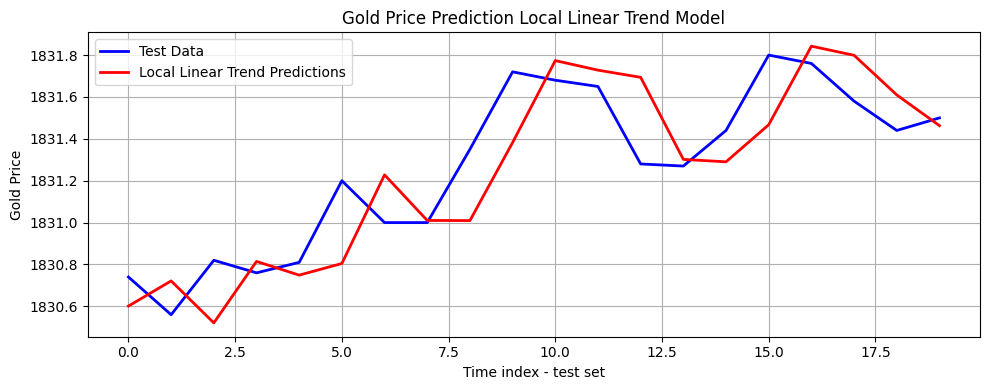

Training set size: 80
Test set size: 20


In [57]:
# use first 100 data points
gold_series = df['open'].values[:100]

# split into train and test sets (ratio 80/20)
y_train, y_test = train_test_split(gold_series, test_size=0.2, shuffle=False)

# fit the model on training data set
energy_fun_train = make_energy_local_linear_trend(y_train, x0=np.array([y_train[0], 0.0]), P0=np.eye(2))
theta0 = np.array([np.log(0.1),np.log(0.1),np.log(0.1)])
res_train = opt.minimize(energy_fun_train, theta0)

# optimized parameters
sigma2_eta = np.exp(res_train.x[0])
sigma2_zeta = np.exp(res_train.x[1])
sigma2_eps = np.exp(res_train.x[2])

# Run the Kalman filter on training data to get the final state
filtered_states_train, filtered_cov_train, filtered_obs_train = filter_local_linear_trend(y_train, sigma2_eta, sigma2_zeta, sigma2_eps, x0=np.array([y_train[0], 0.0]), P0=np.eye(2))

x0_test = filtered_states_train[-1].flatten()  # Convert from (2,1) to (2,)
P0_test = filtered_cov_train[-1]

# fit and predict on test data set
res, mse, error_list, predictions_test, filtered_states_test, filtered_obs_test = fit_and_predict_local_linear_trend(y_train, y_test, x0_test, P0_test)

log_sigma2_eta = res.x[0]
log_sigma2_zeta = res.x[1]
log_sigma2_eps = res.x[2]
print(f'log_sigma2_eta: {log_sigma2_eta}, log_sigma2_zeta: {log_sigma2_zeta}, log_sigma2_eps: {log_sigma2_eps}')
print(f'MSE: {mse}')

# Convert predictions to 1D array for plotting
predictions_flat = np.array(predictions_test).flatten()

# plot only y_test

plt.figure(figsize=(10,4))
plt.plot(y_test, label='Test Data', linewidth=2, color='blue')
plt.plot(predictions_flat, label='Local Linear Trend Predictions', linewidth=2, color='red')
plt.title('Gold Price Prediction Local Linear Trend Model')
plt.xlabel('Time index - test set')
plt.ylabel('Gold Price')
plt.tight_layout()
plt.legend()
plt.grid(True)
plt.show()


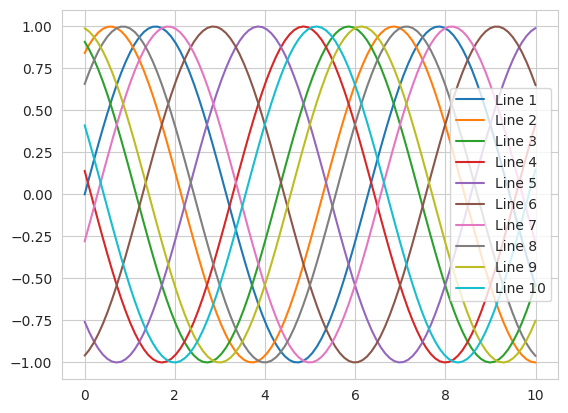

((0.12156862745098039, 0.4666666666666667, 0.7058823529411765), (1.0, 0.4980392156862745, 0.054901960784313725), (0.17254901960784313, 0.6274509803921569, 0.17254901960784313), (0.8392156862745098, 0.15294117647058825, 0.1568627450980392), (0.5803921568627451, 0.403921568627451, 0.7411764705882353), (0.5490196078431373, 0.33725490196078434, 0.29411764705882354), (0.8901960784313725, 0.4666666666666667, 0.7607843137254902), (0.4980392156862745, 0.4980392156862745, 0.4980392156862745), (0.7372549019607844, 0.7411764705882353, 0.13333333333333333), (0.09019607843137255, 0.7450980392156863, 0.8117647058823529))


In [4]:
colors = plt.cm.tab10.colors  # 10 distinct colors
for i, c in enumerate(colors):
    plt.plot(x, np.sin(x + i), color=c, label=f"Line {i+1}")
plt.legend()
plt.show()

print(colors)